# WQI 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, stats, linregress

## Data correction

In [2]:
data=pd.read_csv("data_Q.csv")
data.columns=['Location','year','month', 'pH','oxid' ,'NO3','hard','dry','Cl','SO4','Fe','F','Cu']
df_Q = pd.DataFrame(data)
dp_Q = df_Q[['pH','oxid' ,'NO3','hard','dry','Cl','SO4','Fe','F','Cu']]
dp_Q.head(10)

,pH,oxid,NO3,hard,dry,Cl,SO4,Fe,F,Cu
0,9.00,10.00,45.000,10.00,1500.000000,350.0,500.000000,10.00,0.70,1.00
1,5.00,0.00,0.000,0.00,0.000000,0.0,0.000000,0.00,0.00,0.00
2,0.11,0.17,0.050,0.07,0.000000,0.0,0.000000,0.00,0.05,0.00
3,7.00,0.00,0.000,0.00,0.000000,0.0,0.000000,0.00,0.00,0.00
4,9.50,5.12,22.700,50.00,3027.000000,893.5,768.000000,1.80,1.14,2.60
5,6.00,0.12,0.661,2.00,1.010932,45.5,1.021818,0.01,0.00,0.00
6,7.90,1.60,9.300,10.10,1386.400000,210.5,153.200000,0.10,0.08,0.11
7,7.90,1.90,9.900,13.20,1589.200000,275.1,204.600000,0.12,0.14,0.18
8,7.70,1.70,9.600,11.20,1522.800000,262.3,168.500000,0.16,0.14,0.12
9,8.30,1.80,9.500,13.50,1569.900000,270.2,206.800000,0.11,0.16,0.15


## Parametr regression

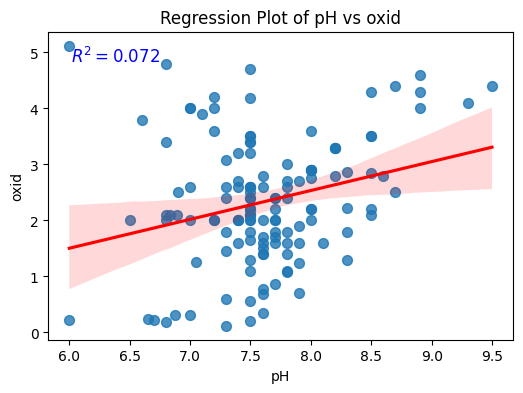

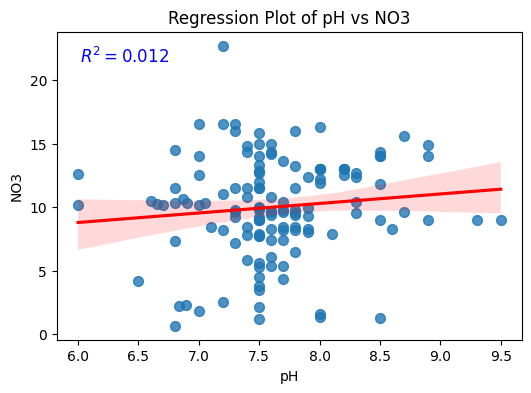

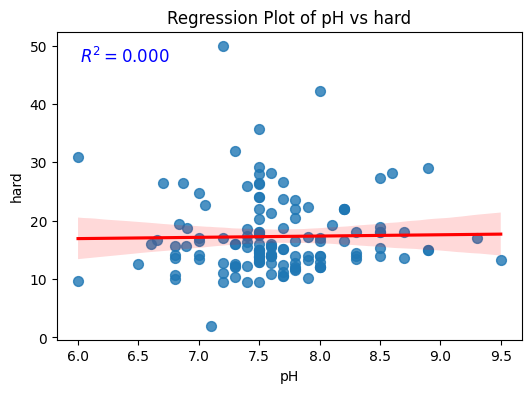

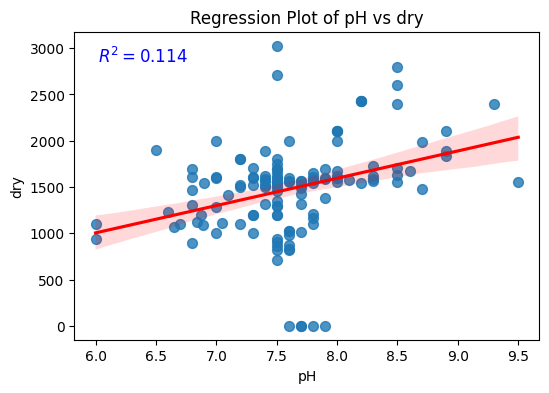

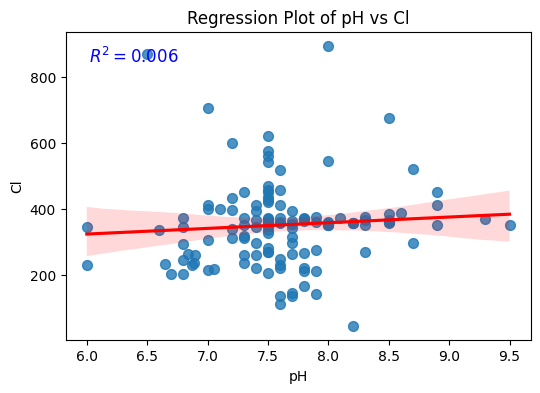

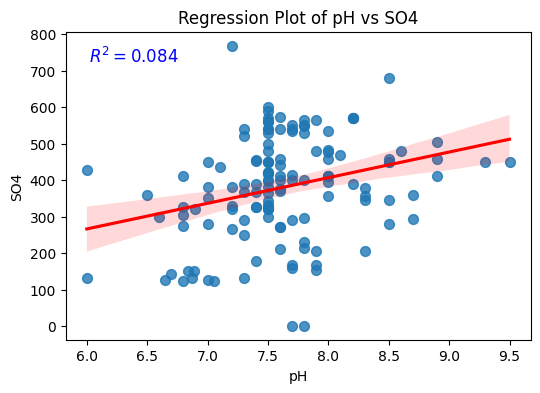

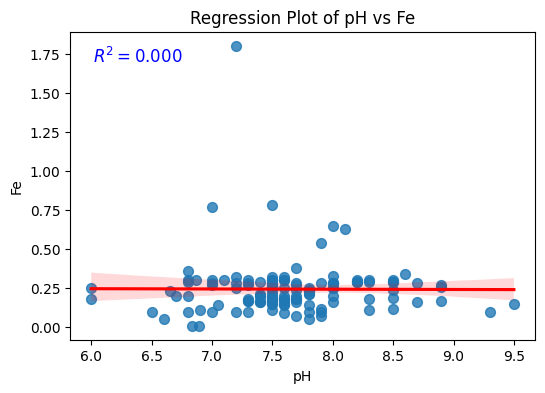

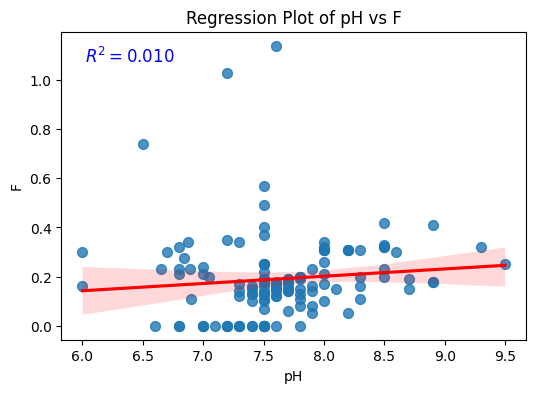

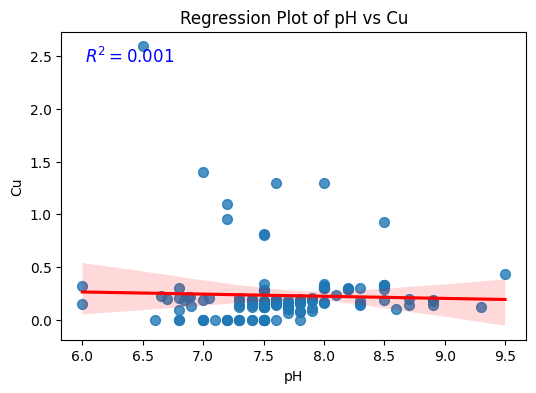

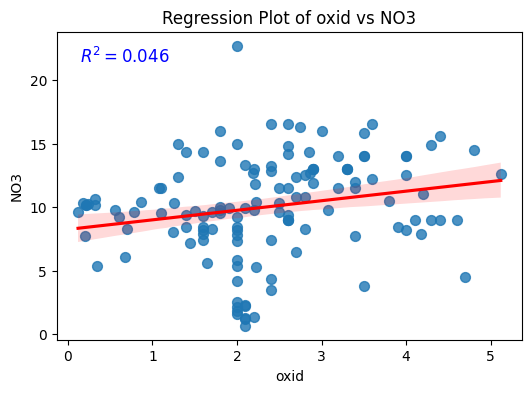

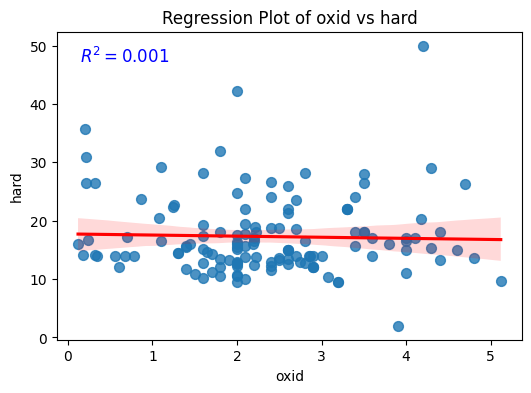

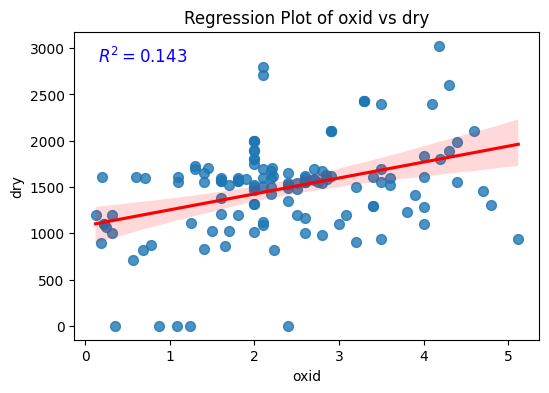

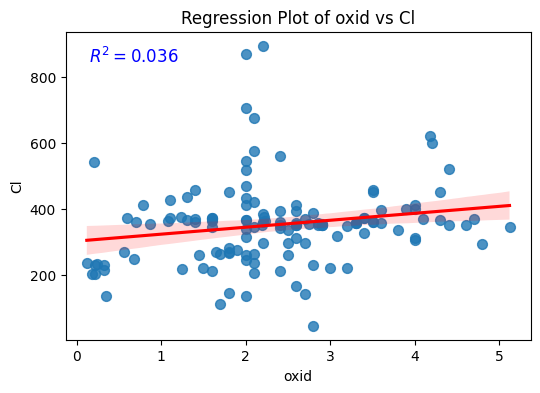

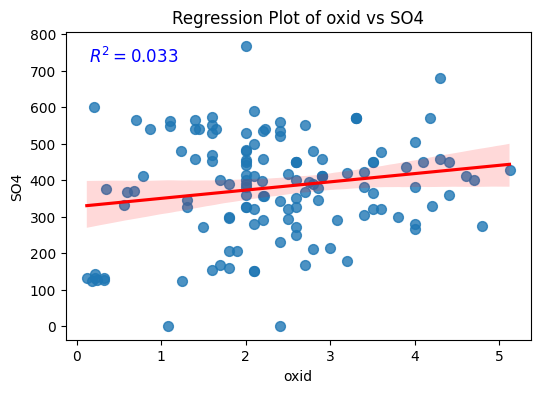

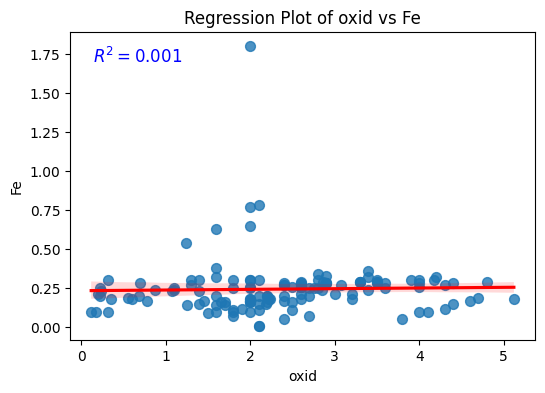

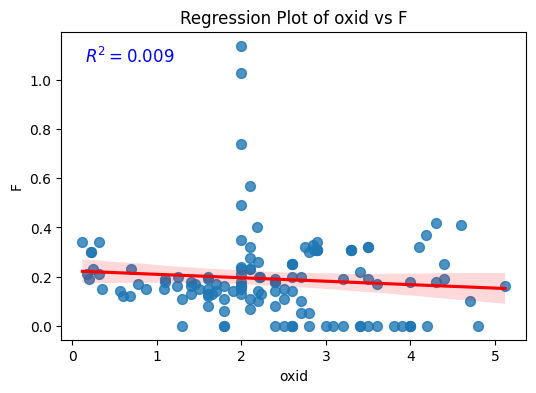

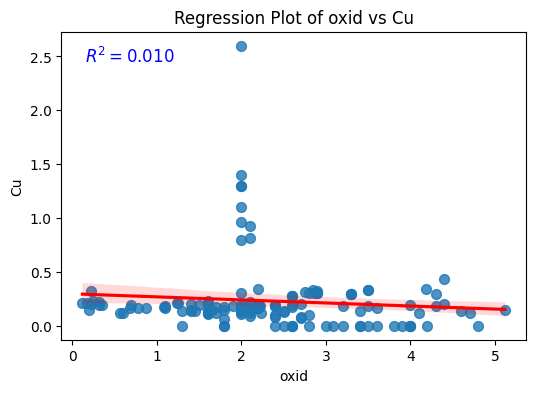

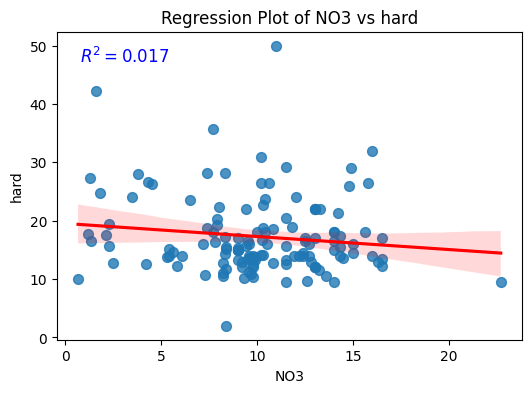

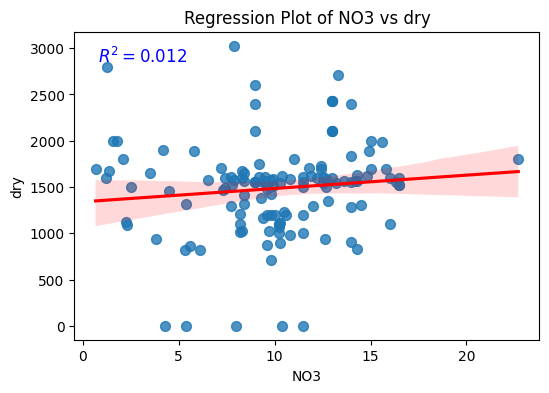

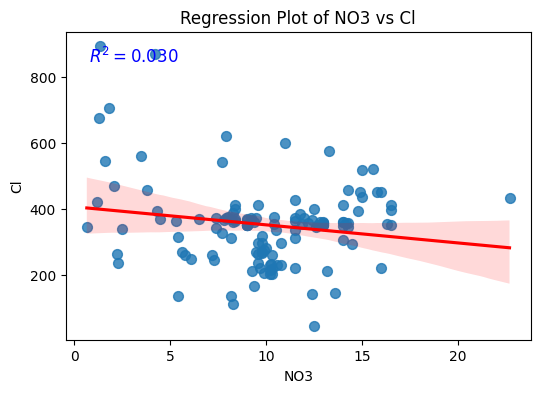

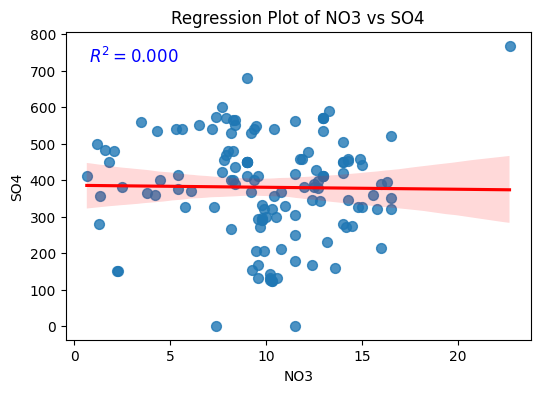

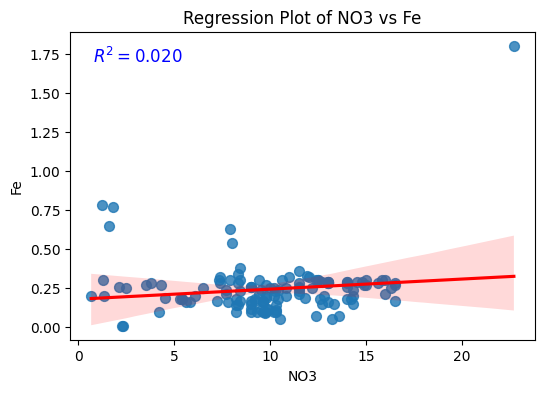

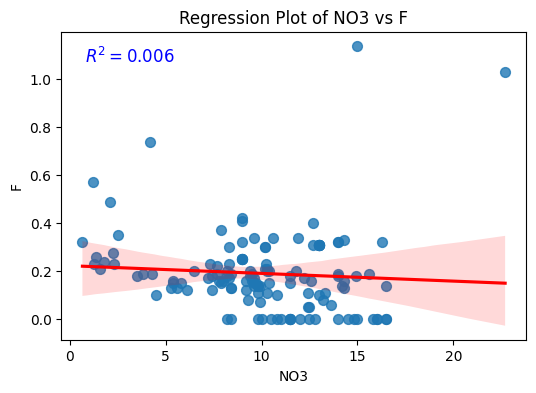

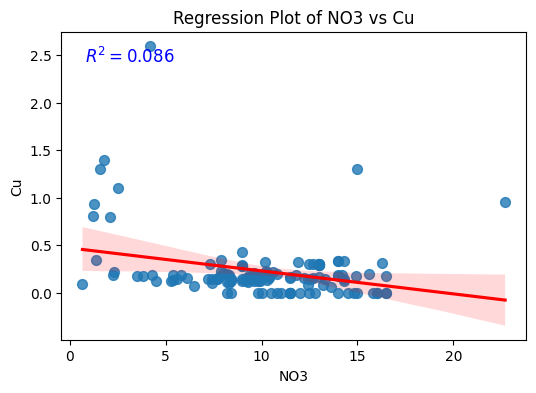

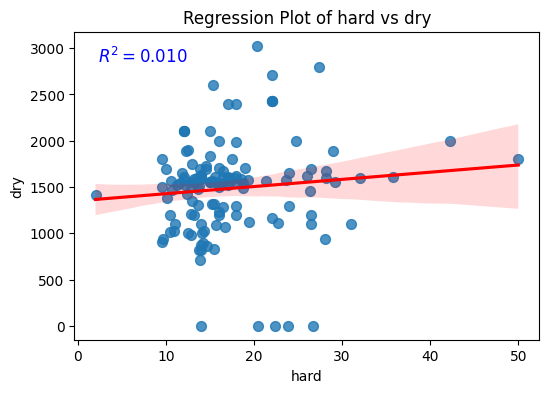

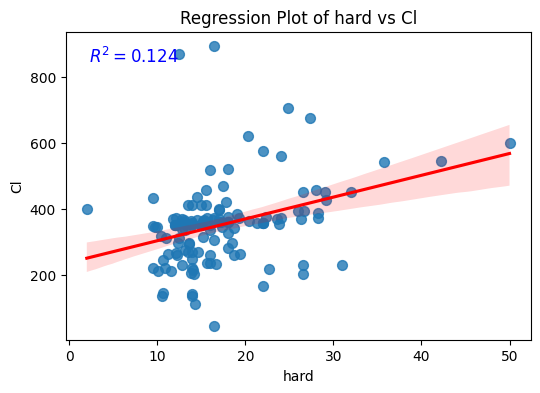

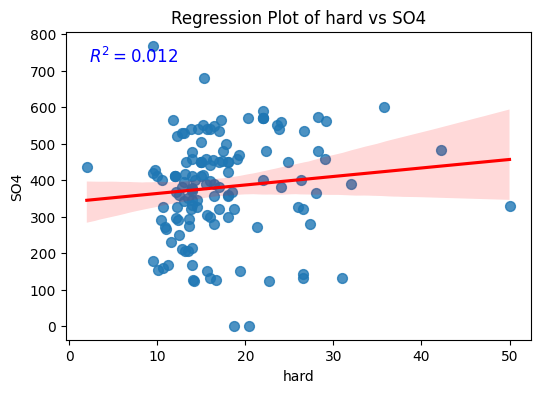

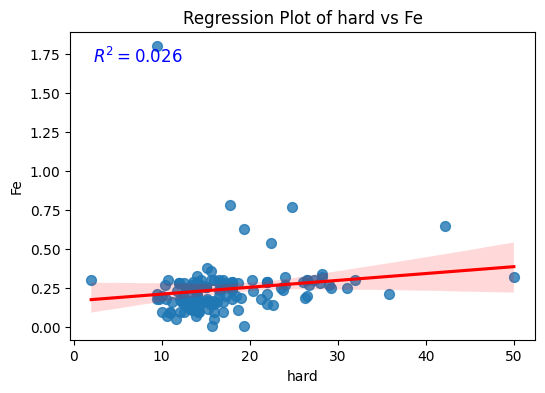

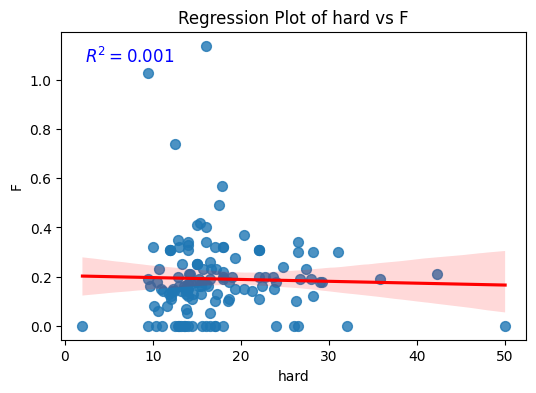

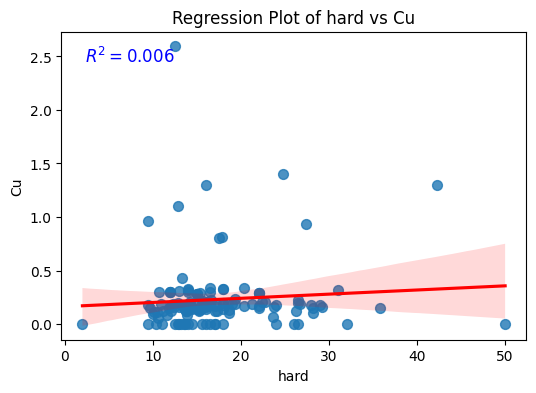

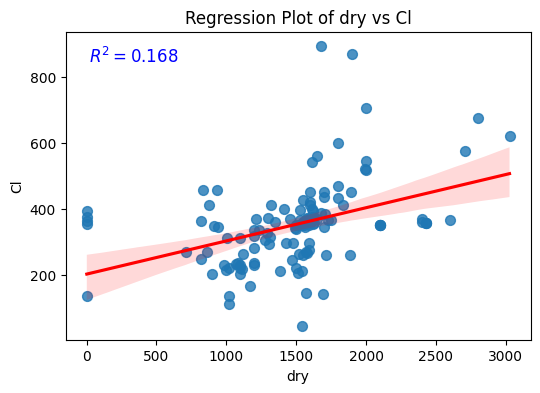

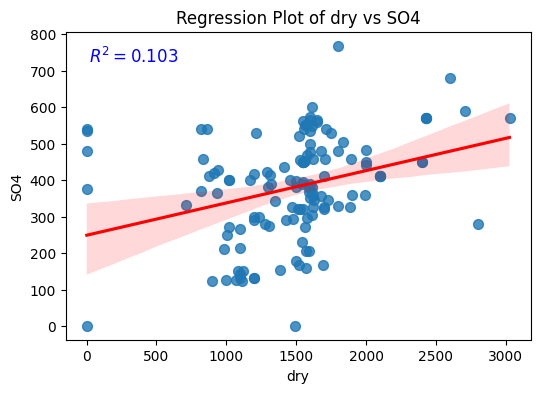

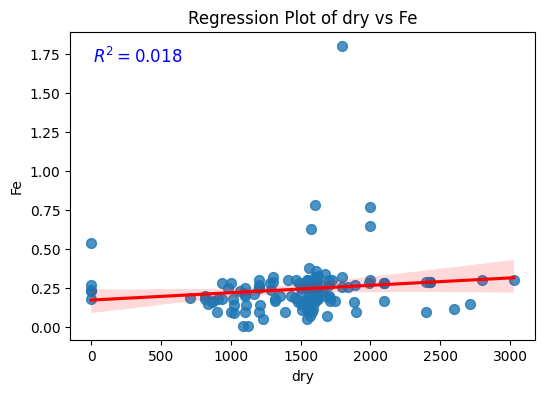

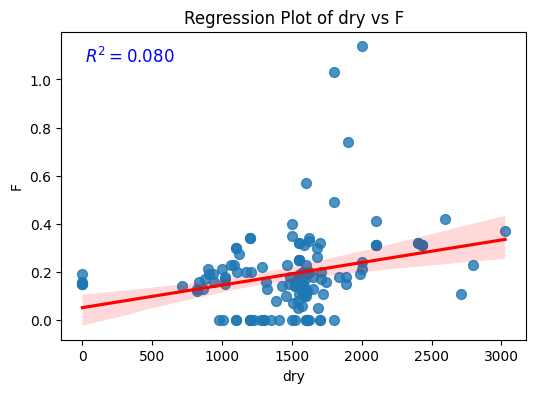

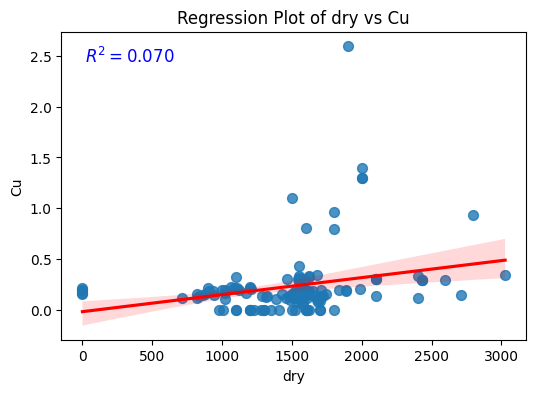

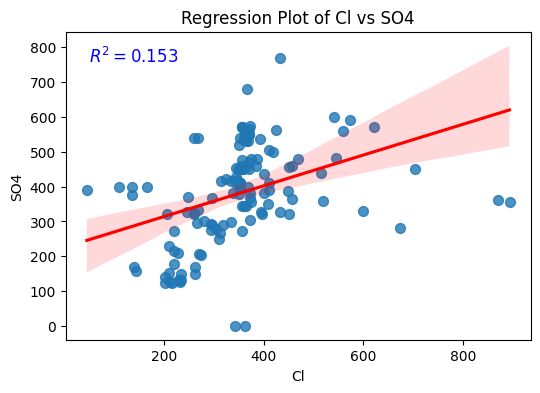

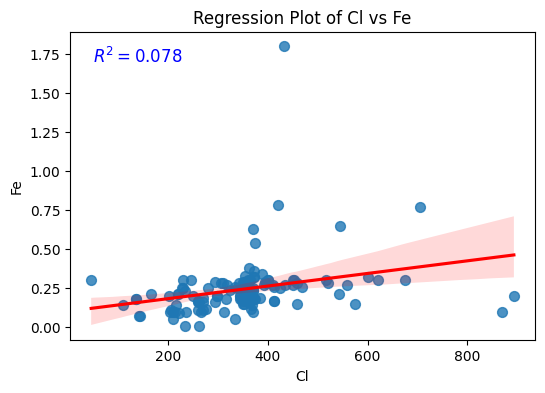

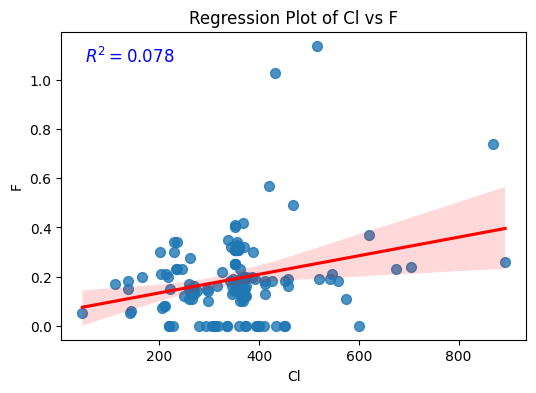

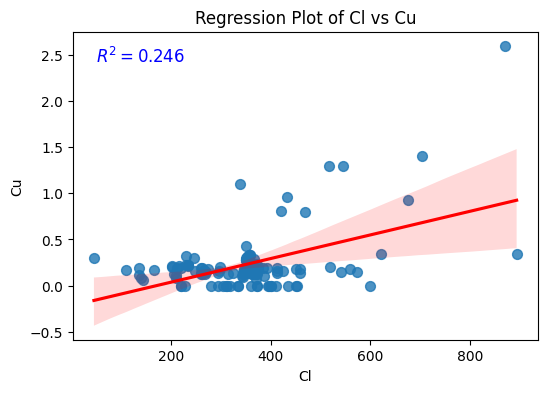

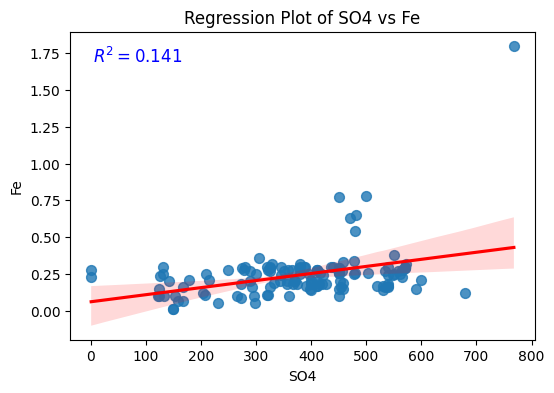

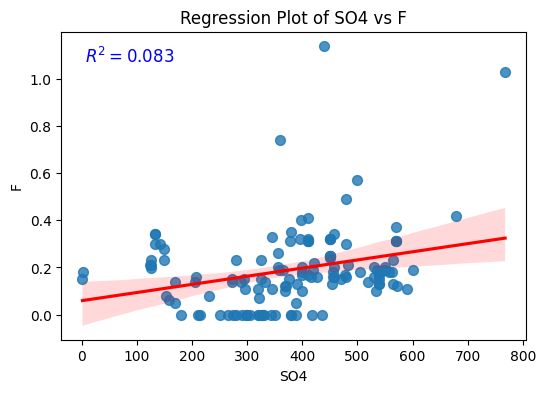

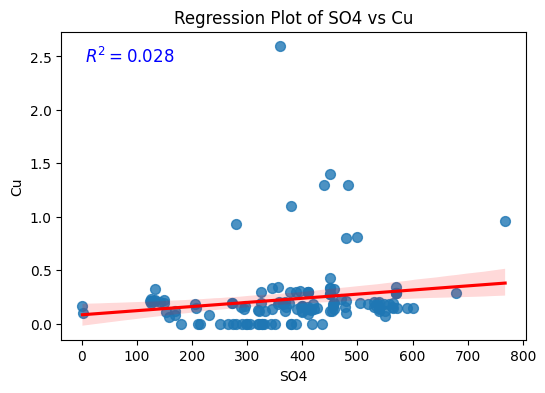

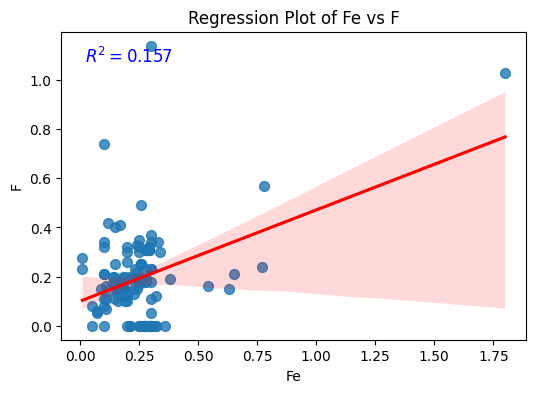

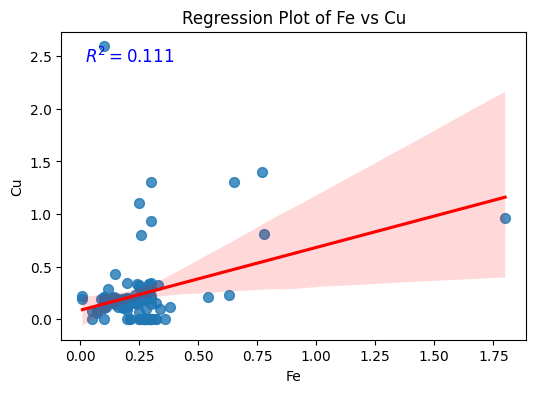

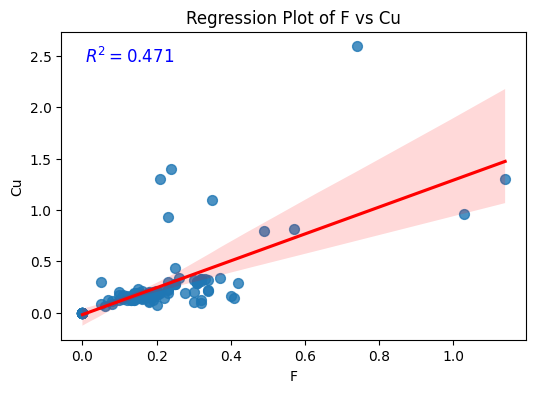

In [3]:
dp=dp_Q.iloc[6:]
columns = dp.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(dp[columns[i]], dp[columns[j]])
        r_squared = r_value ** 2

        # Plot regression
        plt.figure(figsize=(6, 4))
        sns.regplot(x=columns[i], y=columns[j], data=dp, scatter_kws={'s': 50}, line_kws={"color": "red"})
        plt.title(f'Regression Plot of {columns[i]} vs {columns[j]}')
        plt.xlabel(columns[i])
        plt.ylabel(columns[j])

        # Annotate plot with R^2 value
        plt.text(0.05, 0.9, f'$R^2 = {r_squared:.3f}$', transform=plt.gca().transAxes, fontsize=12, color='blue')

        plt.show()

## Parametr correlation and Pearson matrixes

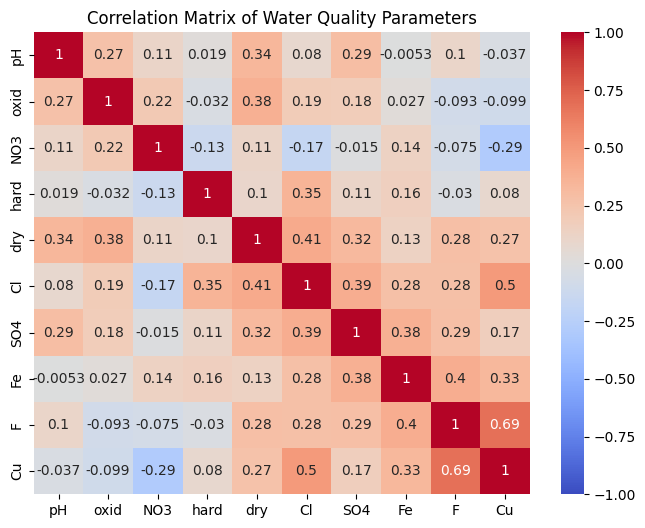

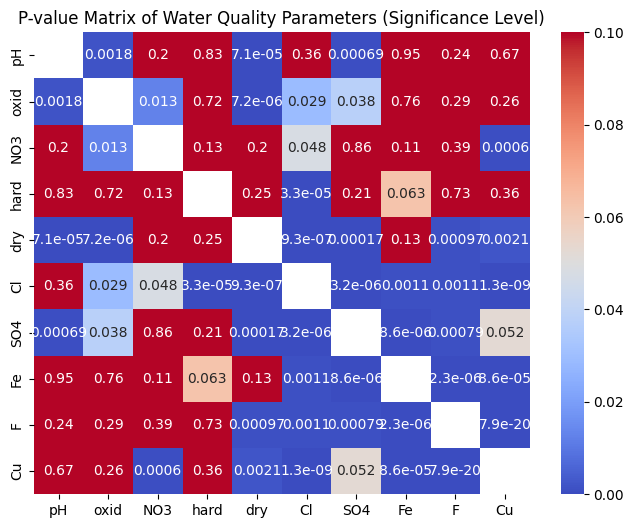

In [4]:
# Calculate the correlation matrix
corr_matrix = dp.corr()

# Optionally visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Water Quality Parameters")
plt.show()

# Initialize an empty DataFrame to hold the p-values
p_values = pd.DataFrame(np.zeros((dp.shape[1], dp.shape[1])), columns=dp.columns, index=dp.columns)

# Calculate the Pearson correlation coefficient and p-value for each pair
for col1 in dp.columns:
    for col2 in dp.columns:
        if col1 != col2:
            corr, p_val = pearsonr(dp[col1], dp[col2])
            p_values.loc[col1, col2] = p_val
        else:
            p_values.loc[col1, col2] = np.nan  # No p-value for correlation of a variable with itself


# Optionally visualize the p-value matrix
plt.figure(figsize=(8, 6))
sns.heatmap(p_values, annot=True, cmap='coolwarm', vmin=0, vmax=0.1)
plt.title("P-value Matrix of Water Quality Parameters (Significance Level)")
plt.show()

## WQI models

### Getting parametrs

In [5]:
## standart values
dp=dp_Q
st_up=dp.iloc[0]
st_low=dp.iloc[1]
x_up=dp.iloc[4]
x_low=dp.iloc[5]

### Sub indexing and results

In [6]:
## Results
def result(x):
  if x<30:
    return 'Poor'
  elif x<50:
    return 'Marginal'
  elif x<80:
    return 'Fair'
  else:
    return 'Good'

In [7]:
## Sub index calculate
#pH=0, oxid=1 ,NO3=3,hard=3,dry=4,Cl=5,SO4=6,Fe=7,F=8,Cu=9
def SI1(x,x_up,x_low):
  return max(0,(x_up-x)/(x_up-x_low)*100)

def SI2(x,x_up,x_low):
  return max(0,(x-x_low)/(x_up-x_low)*100)

def SI(i,x,x_up,x_low):
  a=[1,2,3,4,5,6,7,8,9]
  if i in a:
    return SI1(x,x_up,x_low)
  else:
    if x<7.5:
      return SI2(x,x_up,x_low)
    elif x>8.5:
      return SI1(x,x_up,x_low)
    else:
      return 100


### NSF model

In [8]:
def NSF(x):

  ## Sub indexing
  s=[]
  for i in range(len(x)):
    si=SI(i,x.iloc[i],x_up.iloc[i],x_low.iloc[i])
    s.append(si)

  ## weights
  w=dp.iloc[2]

  ## calculation NSF WQI
  NSF=round(np.dot(s,w))
  return NSF, result(NSF)

x=dp.iloc[6]
NSF(x)

(36, 'Marginal')

### CCME model

In [9]:
def CCME(x):
  Total_p=len(x)
  Failed_p=0
  for i in range(len(x)):
    if x.iloc[i]>st_up.iloc[i]:
      Failed_p=+1
  F1=Failed_p/Total_p*100
  F2=F1
  exceursion=0
  for i in range(len(x)):
    if x.iloc[i]>st_up.iloc[i]:
      exceursion=exceursion+x.iloc[i]/st_up.iloc[i]-1
  nse=exceursion/Total_p
  F3=nse/(1+nse)*100
  CCME=100-np.sqrt(F1*F1+F2*F2+F3*F3)/1.732
  return round(CCME), result(CCME)

x=dp.iloc[6]
CCME(x)

(92, 'Good')

### WA (Weighted avarage) model

In [10]:
def WA(x):
  # calculating weights
  ssi=[1/s for s in st_up]
  S=np.sum(ssi)
  w=[s/S for s in ssi]
  ## Sub indexing
  s=[]
  for i in range(len(x)):
    si=100-SI(i,x.iloc[i],st_up.iloc[i],st_low.iloc[i])
    s.append(si)

  # calculating index
  WA=max(0,100-np.dot(s,w))
  return round(WA), result(WA)

x=dp.iloc[6]
WA(x)

(86, 'Good')

### DWA (Dynamic weighted avarage) model --- Suggested model

In [11]:
## Sub index calculate
# pH=0, oxid=1 ,NO3=3,hard=3,dry=4,Cl=5,SO4=6,Fe=7,F=8,Cu=9
def QI1(x,x_up,x_low):
  return min(100,(x-x_low)/(x_up-x_low)*100)


def QI(i,x,x_up,x_low):
  a=[1,2,3,4,5,6,7,8,9]
  if i in a:
    return QI1(x,x_up,x_low)
  else:
    return abs(QI1(x,x_up,(x_up+x_low)/2))


# Calculating DWA WQI

def DWA(x):
  ## Sub indexing
  s=[]
  ss=[]
  for i in range(len(x)):
    si=QI(i,x.iloc[i],st_up.iloc[i],st_low.iloc[i])
    s.append(si)
    ss.append(np.exp((si/100)))
  S=np.sum(ss)

  # weights
  w=[x/S for x in ss]

  #Calculating WQI
  DWA=100-max(0,np.dot(s,w))
  return round(DWA), result(DWA)

x=dp.iloc[6]
DWA(x)

(49, 'Marginal')

## Eclipsing impacts Hypothesis testing

### Creating data to compare models

In [12]:
t_NSF=[]
t_CCME=[]
t_WA=[]
t_DWA=[]
d_NSF=[]
d_CCME=[]
d_WA=[]
d_DWA=[]

for i in range(len(dp.iloc[6:])):
  x=dp.iloc[i+6]
  t_NSF.append(NSF(x)[0])
  t_CCME.append(CCME(x)[0])
  t_WA.append(WA(x)[0])
  t_DWA.append(DWA(x)[0])
  d_NSF.append(NSF(x)[1])
  d_CCME.append(CCME(x)[1])
  d_WA.append(WA(x)[1])
  d_DWA.append(DWA(x)[1])

df=dp.iloc[6:]
df = df.assign(NSF=d_NSF)
df['CCME']=d_CCME
df['WA']=d_WA
df['DWA']=d_DWA
df['NSFn']=t_NSF
df['CCMEn']=t_CCME
df['WAn']=t_WA
df['DWAn']=t_DWA

df.head(5)

,pH,oxid,NO3,hard,dry,Cl,SO4,Fe,F,Cu,NSF,CCME,WA,DWA,NSFn,CCMEn,WAn,DWAn
6,7.9,1.6,9.3,10.1,1386.4,210.5,153.2,0.10,0.08,0.11,Marginal,Good,Good,Marginal,36,92,86,49
7,7.9,1.9,9.9,13.2,1589.2,275.1,204.6,0.12,0.14,0.18,Marginal,Good,Fair,Marginal,35,92,79,43
8,7.7,1.7,9.6,11.2,1522.8,262.3,168.5,0.16,0.14,0.12,Marginal,Good,Good,Marginal,36,92,81,45
9,8.3,1.8,9.5,13.5,1569.9,270.2,206.8,0.11,0.16,0.15,Marginal,Good,Fair,Marginal,35,92,79,41
10,7.6,1.5,9.7,10.9,1022.3,221.0,272.2,0.09,0.15,0.19,Marginal,Good,Fair,Fair,36,92,78,51


### Write CSV file

In [13]:
df.to_csv('data_Eclipsing_uzb.csv', index=False)

### Test hypotesis for Good water

#### Creating  Good Data to test Models  with Monte Carlo Simulated Gaussian Process

In [14]:
mean_values=dp_Q.iloc[3]
std_up=dp_Q.iloc[0]
std_values=0.2*(st_up-mean_values)

num_samples = 10000  # Adjust the number of samples as needed
new_data = np.random.normal(mean_values, std_values, (num_samples, len(mean_values)))

good_df = pd.DataFrame(new_data, columns=dp_Q.columns)
good_df = good_df.map(lambda x: abs(x))


for i, row in good_df.iterrows():
    bool_value = 1
    for j in range(len(row)):
        if not (mean_values.iloc[j]-1*std_values.iloc[j] <= row.iloc[j] <=mean_values.iloc[j]+ 1*std_values.iloc[j]):
            bool_value = 0
            break
    if bool_value == 0:
        good_df=good_df.drop(i, axis=0)

print(len(good_df))
good_df.head()

237


,pH,oxid,NO3,hard,dry,Cl,SO4,Fe,F,Cu
25,6.958392,1.566936,0.139089,0.775512,5.171321,26.782732,27.977543,0.634877,0.067236,0.172602
57,7.179689,1.776835,4.136434,1.792021,2.342936,11.210970,17.804121,1.762033,0.056375,0.023096
65,7.021147,1.169588,6.055723,0.142909,56.572153,34.071462,4.221372,1.450189,0.099237,0.121877
101,6.699084,1.720757,4.073609,1.266051,170.310523,47.822699,3.068256,0.388792,0.115368,0.171673
103,7.323226,0.822697,1.087567,0.374977,69.962521,11.316444,3.832745,1.287838,0.055356,0.015398


#### Testing models for good criteria

Biz quyidagi tasdiq uchun modelni tekshiramiz.

Agar hamma parametrlar standart qiymatiga nisbatan 20% dan ko'p bo'lmagan chetlanishga ega bo'lsa, bu suv yaxshi "Good".

{'NSF': 0, 'CCME': 237, 'WA': 237, 'DWA': 237}


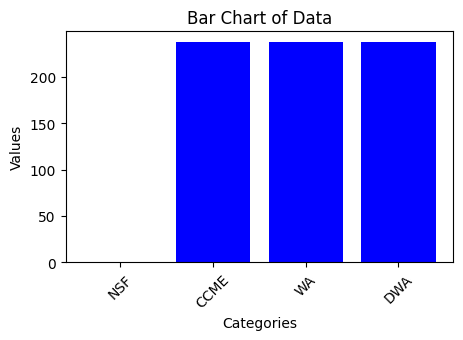

In [15]:
t_NSF=0
t_CCME=0
t_WA=0
t_DWA=0

for i in range(len(good_df)):
  x=good_df.iloc[i]
  if NSF(x)[1]=='Good': t_NSF+=1
  if CCME(x)[1]=='Good': t_CCME+=1
  if WA(x)[1]=='Good': t_WA+=1
  if DWA(x)[1]=='Good': t_DWA+=1


tg={'NSF':t_NSF,'CCME':t_CCME,'WA':t_WA,'DWA':t_DWA}
print(tg)
# Extract data for plotting
labels = list(tg.keys())
values = list(tg.values())

# Create the bar chart
plt.figure(figsize=(5, 3))
plt.bar(labels, values, color='blue')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Chart of Data')

# Rotate labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

#### Hypothesis testing for Good water

In [20]:
from scipy.stats import binomtest

H0 = 0.95   # null hypothesis
alpha = 0.05  # Significance level

L=len(good_df)
print(L)
print('p-values')
for model_name in tg:
    p_values = binomtest(tg[model_name], L, p=H0, alternative='less').pvalue
    if p_values < alpha:
        text='H0 qabul qilinmasligiga statistik asos bor'
    else:
        text='H0 qabul qilinishiga statistik asos bor'

    print(model_name,'----',f"{p_values:.3f}",'----',text)

237
p-values
NSF ---- 0.000 ---- H0 qabul qilinmasligiga statistik asos bor
CCME ---- 1.000 ---- H0 qabul qilinishiga statistik asos bor
WA ---- 1.000 ---- H0 qabul qilinishiga statistik asos bor
DWA ---- 1.000 ---- H0 qabul qilinishiga statistik asos bor


### Test hypothesis for Poor water

3 tadan ko'p parametri normadan oshgan suvni yomon 'poor' deymiz.

#### Creating poor water data

In [21]:
mean_values=dp_Q.iloc[3]
std_up=dp_Q.iloc[0]
std_values=2*(st_up-mean_values)

num_samples = 1000  # Adjust the number of samples as needed
new_data = np.random.normal(mean_values, std_values, (num_samples, len(mean_values)))

poor_df = pd.DataFrame(new_data, columns=dp_Q.columns)
poor_df = poor_df.map(lambda x: abs(x))


for i, row in poor_df.iterrows():
    bool_value = 0
    for j in range(len(row)):
        if not (mean_values.iloc[j]-1*std_values.iloc[j] <= row.iloc[j] <=mean_values.iloc[j]+ 1*std_values.iloc[j]):
            bool_value = bool_value+1
    if bool_value <2:
        poor_df=poor_df.drop(i, axis=0)


print(len(poor_df))
poor_df.head()

883


,pH,oxid,NO3,hard,dry,Cl,SO4,Fe,F,Cu
0,5.512753,19.942070,87.890360,3.284308,4287.258872,284.961233,433.454346,40.889703,1.931815,0.009988
1,3.455523,26.957845,164.028854,11.938935,489.830104,723.777122,1871.419778,33.221779,2.424191,1.876495
2,10.150908,2.007850,82.222690,5.368137,5082.041517,968.098458,787.111833,44.903442,0.896990,2.824767
3,7.183596,45.823086,23.320188,16.617167,4742.676197,578.530261,367.969533,14.714580,1.759133,2.292006
4,12.053949,24.323290,102.034111,4.914546,2483.837617,330.054851,1084.506040,11.894033,0.597532,0.527957


#### Testing models for poor criteria

{'NSF': 876, 'CCME': 0, 'WA': 660, 'DWA': 878}


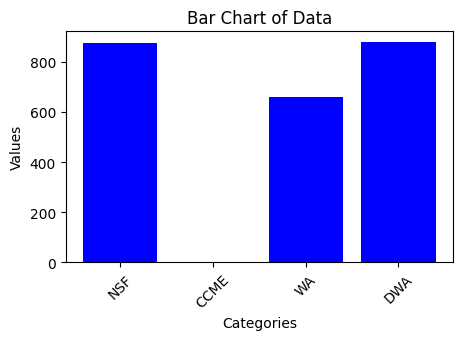

In [22]:
t_NSF=0
t_CCME=0
t_WA=0
t_DWA=0

for i in range(len(poor_df)):
  x=poor_df.iloc[i]
  if NSF(x)[1]=='Poor': t_NSF+=1
  if CCME(x)[1]=='Poor': t_CCME+=1
  if WA(x)[1]=='Poor': t_WA+=1
  if DWA(x)[1]=='Poor': t_DWA+=1


tp={'NSF':t_NSF,'CCME':t_CCME,'WA':t_WA,'DWA':t_DWA}
print(tp)
# Extract data for plotting
labels = list(tp.keys())
values = list(tp.values())

# Create the bar chart
plt.figure(figsize=(5, 3))
plt.bar(labels, values, color='blue')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Chart of Data')

# Rotate labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

#### Hypothesis testing for Poor water

In [24]:
H0 = 0.95   # null hypothesis
alpha = 0.05  # Significance level

L=len(poor_df)
print(L)
print('p-values')
for model_name in tp:
    p_values = binomtest(tp[model_name], L, p=H0, alternative='less').pvalue
    if p_values < alpha:
        text='H0 qabul qilinmasligiga statistik asos bor'
    else:
        text='H0 qabul qilinishiga statistik asos bor'

    print(model_name,'----',f"{p_values:.3f}",'----',text)

883
p-values
NSF ---- 1.000 ---- H0 qabul qilinishiga statistik asos bor
CCME ---- 0.000 ---- H0 qabul qilinmasligiga statistik asos bor
WA ---- 0.000 ---- H0 qabul qilinmasligiga statistik asos bor
DWA ---- 1.000 ---- H0 qabul qilinishiga statistik asos bor


### Test hypotesis for Fair waters

Agar hamma parametrlar standart qiymatiga nisbatan 25% dan ko'p va 50% dan kam  chetlanishga ega bo'lsa, bu suv durust "Fair".

#### Creating fair water data

In [25]:
mean_values=dp_Q.iloc[3]
std_up=dp_Q.iloc[0]

std_values=0.001*(st_up-mean_values)
mean_values=mean_values+250*std_values

num_samples = 10000  # Adjust the number of samples as needed
new_data = np.random.normal(mean_values, std_values, (num_samples, len(mean_values)))

fair_df = pd.DataFrame(new_data, columns=dp_Q.columns)
fair_df = fair_df.map(lambda x: abs(x))

mean_values=dp_Q.iloc[3]
std_values=0.5*(st_up-mean_values)

for i, row in fair_df.iterrows():
    bool_value = 1
    for j in range(len(row)):
        if (not (mean_values.iloc[j]-1*std_values.iloc[j] < row.iloc[j] <mean_values.iloc[j]+ 1*std_values.iloc[j])) or (mean_values.iloc[j]-0.5*std_values.iloc[j] < row.iloc[j] <mean_values.iloc[j]+ 0.5*std_values.iloc[j]):
            bool_value = 0
            break
    if bool_value ==0:
        fair_df=fair_df.drop(i, axis=0)


print(len(fair_df))
fair_df.head()

10


,pH,oxid,NO3,hard,dry,Cl,SO4,Fe,F,Cu
1107,7.500961,2.508790,11.284072,2.500313,376.041032,87.650940,125.153859,2.504045,0.175008,0.250150
1469,7.500252,2.507786,11.296967,2.507956,375.079939,87.878952,125.457594,2.501246,0.175647,0.250575
2634,7.502058,2.510006,11.318494,2.500434,375.761574,87.802976,125.547614,2.507145,0.175221,0.250838
3243,7.504343,2.505687,11.289836,2.519659,376.601649,88.132114,125.233504,2.500254,0.175181,0.250651
3353,7.504048,2.505821,11.267662,2.503330,376.448759,87.672880,125.326818,2.500901,0.175156,0.250519


#### Testing models for Fair water criteria

{'NSF': 0, 'CCME': 0, 'WA': 10, 'DWA': 10}


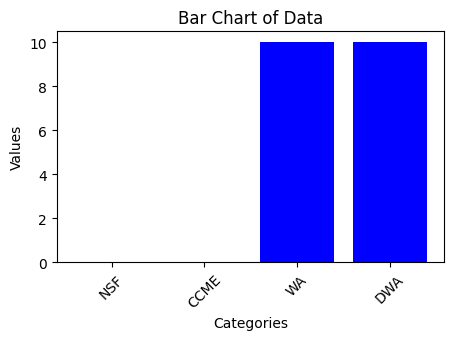

In [26]:
t_NSF=0
t_CCME=0
t_WA=0
t_DWA=0

for i in range(len(fair_df)):
  x=fair_df.iloc[i]
  if NSF(x)[1]== 'Fair': t_NSF+=1
  if CCME(x)[1]=='Fair': t_CCME+=1
  if WA(x)[1]==  'Fair': t_WA+=1
  if DWA(x)[1]== 'Fair': t_DWA+=1


tf={'NSF':t_NSF,'CCME':t_CCME,'WA':t_WA,'DWA':t_DWA}
print(tf)
# Extract data for plotting
labels = list(tf.keys())
values = list(tf.values())

# Create the bar chart
plt.figure(figsize=(5, 3))
plt.bar(labels, values, color='blue')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Chart of Data')

# Rotate labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

#### Hypothesis testing for Fair water

In [28]:
H0 = 0.95   # null hypothesis
alpha = 0.05  # Significance level

L=len(fair_df)
print(L)
print('p-values')
for model_name in tf:
    p_values = binomtest(tf[model_name], L, p=H0, alternative='less').pvalue
    if p_values < alpha:
        text='H0 qabul qilinmasligiga statistik asos bor'
    else:
        text='H0 qabul qilinishiga statistik asos bor'

    print(model_name,'----',f"{p_values:.3f}",'----',text)

10
p-values
NSF ---- 0.000 ---- H0 qabul qilinmasligiga statistik asos bor
CCME ---- 0.000 ---- H0 qabul qilinmasligiga statistik asos bor
WA ---- 1.000 ---- H0 qabul qilinishiga statistik asos bor
DWA ---- 1.000 ---- H0 qabul qilinishiga statistik asos bor


### Test hypotesis for Marginal waters

Agar hamma parametrlar standart qiymatiga nisbatan 60% dan ko'p va 90% dan kam  chetlanishga ega bo'lsa, bu suv yomonga yaqin "Marginal".

#### Create Marginal data 

In [29]:
mean_values=dp_Q.iloc[3]
std_up=dp_Q.iloc[0]

std_values=0.05*(st_up-mean_values)
mean_values=mean_values+13*std_values

num_samples = 1000  # Adjust the number of samples as needed
new_data = np.random.normal(mean_values, std_values, (num_samples, len(mean_values)))

Marginal_df = pd.DataFrame(new_data, columns=dp_Q.columns)
Marginal_df = Marginal_df.map(lambda x: abs(x))

mean_values=dp_Q.iloc[3]
std_values=(st_up-mean_values)

for i, row in Marginal_df.iterrows():
    bool_value = 1
    for j in range(len(row)):
        if (not (mean_values.iloc[j]-0.8*std_values.iloc[j] < row.iloc[j] <mean_values.iloc[j]+ 0.8*std_values.iloc[j])) or (mean_values.iloc[j]-0.6*std_values.iloc[j] < row.iloc[j] <mean_values.iloc[j]+ 0.6*std_values.iloc[j]):
            bool_value = 0
            break
    if bool_value ==0:
        Marginal_df=Marginal_df.drop(i, axis=0)


print(len(Marginal_df))
Marginal_df.head()

173


,pH,oxid,NO3,hard,dry,Cl,SO4,Fe,F,Cu
0,8.251144,7.087558,30.189487,6.716882,988.396983,222.466313,336.023087,6.520104,0.450819,0.658339
5,8.222261,7.359849,34.496311,6.686316,1013.457690,250.865690,359.137299,6.394149,0.441065,0.677386
10,8.484411,6.227084,29.911128,6.528997,1068.010050,239.631412,313.580619,6.655068,0.482363,0.703725
22,8.297623,6.822183,29.663099,6.525042,944.672849,242.314480,313.143200,6.700192,0.439191,0.623358
38,8.273510,6.193723,30.446351,6.307486,934.927202,219.412989,389.896161,7.038574,0.464600,0.638226


#### Testing models for Marginal water criteria

{'NSF': 0, 'CCME': 0, 'WA': 172, 'DWA': 172}


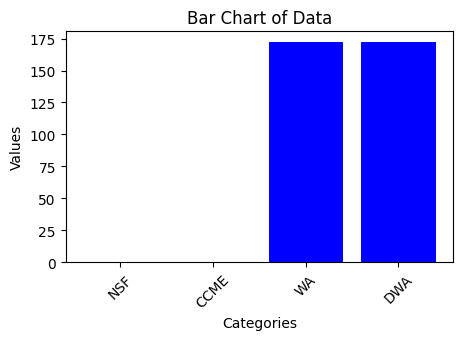

In [30]:
t_NSF=0
t_CCME=0
t_WA=0
t_DWA=0

for i in range(len(Marginal_df)):
  x=Marginal_df.iloc[i]
  if NSF(x)[1]== 'Marginal': t_NSF+=1
  if CCME(x)[1]=='Marginal': t_CCME+=1
  if WA(x)[1]==  'Marginal': t_WA+=1
  if DWA(x)[1]== 'Marginal': t_DWA+=1


tm={'NSF':t_NSF,'CCME':t_CCME,'WA':t_WA,'DWA':t_DWA}
print(tm)
# Extract data for plotting
labels = list(tm.keys())
values = list(tm.values())

# Create the bar chart
plt.figure(figsize=(5, 3))
plt.bar(labels, values, color='blue')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Chart of Data')

# Rotate labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

#### Hypotesis testing for Marginal water

In [31]:
H0 = 0.95   # null hypothesis
alpha = 0.05  # Significance level

L=len(Marginal_df)
print(L)
print('p-values')
for model_name in tm:
    p_values = binomtest(tm[model_name], L, p=H0, alternative='less').pvalue
    if p_values < alpha:
        text='H0 qabul qilinmasligiga statistik asos bor'
    else:
        text='H0 qabul qilinishiga statistik asos bor'

    print(model_name,'----',f"{p_values:.3f}",'----',text)

173
p-values
NSF ---- 0.000 ---- H0 qabul qilinmasligiga statistik asos bor
CCME ---- 0.000 ---- H0 qabul qilinmasligiga statistik asos bor
WA ---- 1.000 ---- H0 qabul qilinishiga statistik asos bor
DWA ---- 1.000 ---- H0 qabul qilinishiga statistik asos bor


### Test Hypothesis for mix water

#### Getting mix water

In [32]:
mix_df = pd.concat([good_df, fair_df, Marginal_df, poor_df], ignore_index=True)
print(len(mix_df))
mix_df.head()

1303


,pH,oxid,NO3,hard,dry,Cl,SO4,Fe,F,Cu
0,6.958392,1.566936,0.139089,0.775512,5.171321,26.782732,27.977543,0.634877,0.067236,0.172602
1,7.179689,1.776835,4.136434,1.792021,2.342936,11.210970,17.804121,1.762033,0.056375,0.023096
2,7.021147,1.169588,6.055723,0.142909,56.572153,34.071462,4.221372,1.450189,0.099237,0.121877
3,6.699084,1.720757,4.073609,1.266051,170.310523,47.822699,3.068256,0.388792,0.115368,0.171673
4,7.323226,0.822697,1.087567,0.374977,69.962521,11.316444,3.832745,1.287838,0.055356,0.015398


#### All distributions

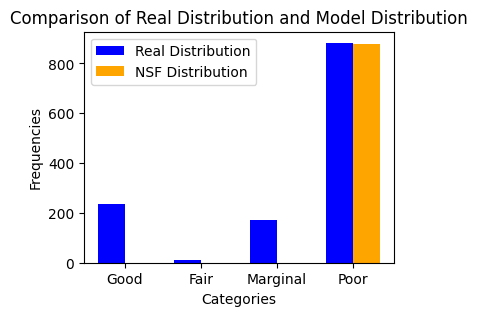

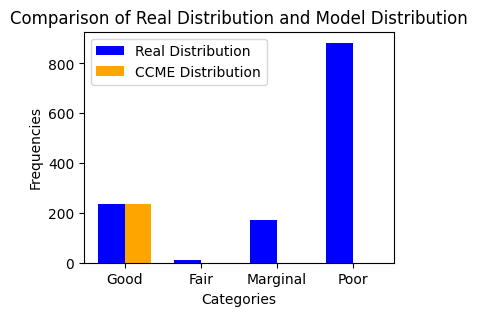

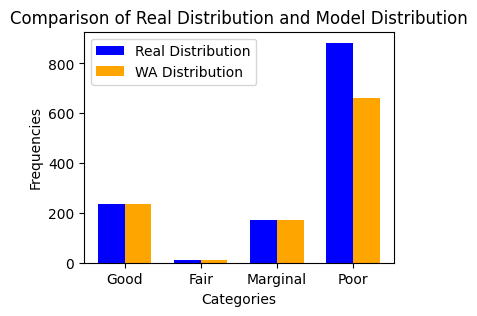

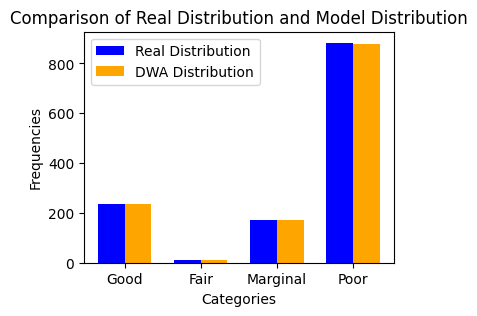

In [33]:
real_dist={'Good':len(good_df),'Fair':len(fair_df),'Marginal':len(Marginal_df),'Poor':len(poor_df)}

dist={}
for model_name in tm:
  dist[model_name]={'Good':tg[model_name],'Fair':tf[model_name],'Marginal':tm[model_name],'Poor':tp[model_name]}

categories = list(real_dist.keys())
real_values = list(real_dist.values())

for model_name in tm:
  model_values = list(dist[model_name].values())

  # Set up the bar chart positions
  x = np.arange(len(categories))  # the label locations
  width = 0.35  # the width of the bars

  # Create the bar chart
  fig, ax = plt.subplots(figsize=(4, 3))

  # Plot bars for real distribution
  ax.bar(x - width/2, real_values, width, label='Real Distribution', color='blue')

  # Plot bars for model distribution
  ax.bar(x + width/2, model_values, width, label=f'{model_name} Distribution', color='orange')


  ax.set_xlabel('Categories')
  ax.set_ylabel('Frequencies')
  ax.set_title('Comparison of Real Distribution and Model Distribution')
  ax.set_xticks(x)
  ax.set_xticklabels(categories)
  ax.legend()

  # Display the plot
  plt.show()


#### Chi-square goodness-of-fit test

In [34]:
from scipy.stats import chisquare


# Extract observed and expected values in the same order
observed = np.array(list(real_dist.values()))


for model_name in tm:
    print(model_name)
    expected = np.array(list(dist[model_name].values()))


    difference = (observed.sum()-expected.sum()) / len(observed)

    # Add the difference equally to each observed value
    expected  = expected  + difference

    chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)


    print(f"Chi-square statistic: {chi2_stat}")
    print(f"P-value: {p_value}")

    # Interpret the result (usually alpha = 0.05)
    alpha = 0.05
    if p_value < alpha:
        print("There is a significant difference between the real distribution and the",model_name," model distribution.")
    else:
        print("There is no significant difference between the real distribution and the",model_name," model distribution.")
    print()

NSF
Chi-square statistic: 297.85012364934465
P-value: 2.904405233898174e-64
There is a significant difference between the real distribution and the NSF  model distribution.

CCME
Chi-square statistic: 1846.8985637125486
P-value: 0.0
There is a significant difference between the real distribution and the CCME  model distribution.

WA
Chi-square statistic: 110.43688436559134
P-value: 8.837162434973183e-24
There is a significant difference between the real distribution and the WA  model distribution.

DWA
Chi-square statistic: 0.22045542675852747
P-value: 0.974221436026247
There is no significant difference between the real distribution and the DWA  model distribution.



## Compare distributions for each models for UZB data

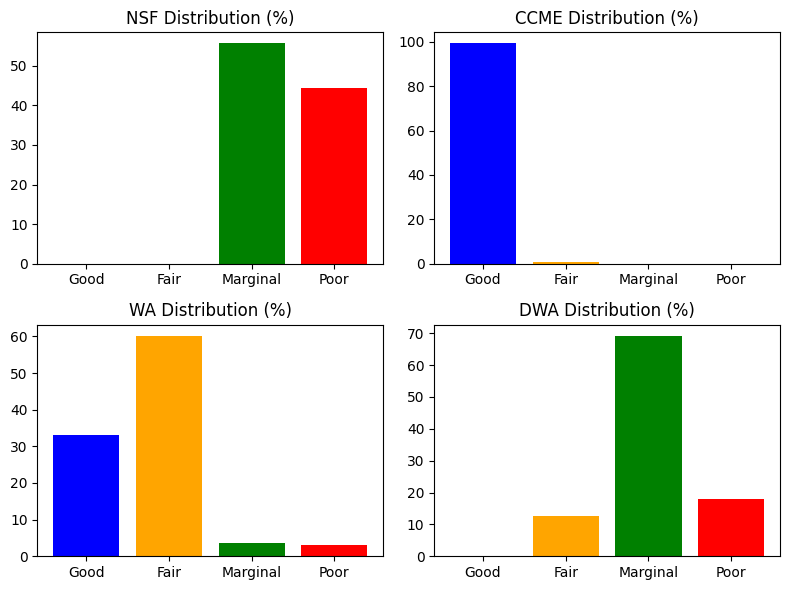

In [35]:
data=pd.read_csv("data_Eclipsing_uzb.csv")
data.columns=['pH','oxid' ,'NO3','hard','dry','Cl','SO4','Fe','F','Cu',	'NSF',	'CCME',	'WA',	'DWA',	'NSFn',	'CCMEn',	'WAn',	'DWAn']
df = pd.DataFrame(data)
df = df[['NSF',	'CCME',	'WA',	'DWA']]

categories = ['Good', 'Fair', 'Marginal', 'Poor']

freq_dict = {}
for col in df.columns:
    value_counts = df[col].value_counts().to_dict()
    freq_dict[col] = {category: value_counts.get(category, 0) for category in categories}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

if len(freq_dict) > 1:
    axes = axes.flatten()

for i, (model, counts) in enumerate(freq_dict.items()):
    total = sum(counts.values())
    percentages = [(counts[cat] / total) * 100 for cat in categories]
    axes[i].bar(categories, percentages, color=['blue', 'orange', 'green', 'red'])
    axes[i].set_title(f'{model} Distribution (%)')


plt.tight_layout()
plt.show()

## Irland

In [36]:
data=pd.read_csv("data_I.csv") # Irland Summer
data.columns=['Location','CHL','DPX','MRP','DIN','AMN','BOD','pH','TEMP','TON','TRAN']
df_I = pd.DataFrame(data)
dp_I = df_I[['CHL','DPX','MRP','DIN','AMN','BOD','pH','TEMP','TON','TRAN']]
df_I.head(5)

,Location,CHL,DPX,MRP,DIN,AMN,BOD,pH,TEMP,TON,TRAN
0,UP,14.200,128.00,0.057,1.208,1.500,7.00,9.00,25.000,2.0,5.00
1,LOW,0.000,72.00,0.000,0.000,0.000,0.00,5.00,0.000,0.0,1.00
2,NSF(weight),0.000,0.17,0.100,0.000,0.000,0.10,0.11,0.050,0.1,0.00
3,WQM(weight),0.109,0.00,0.044,0.228,0.073,0.02,0.00,0.156,0.0,0.37
4,Max,10.433,136.20,0.064,6.021,0.260,3.55,8.30,16.900,6.0,5.60


### Correlation

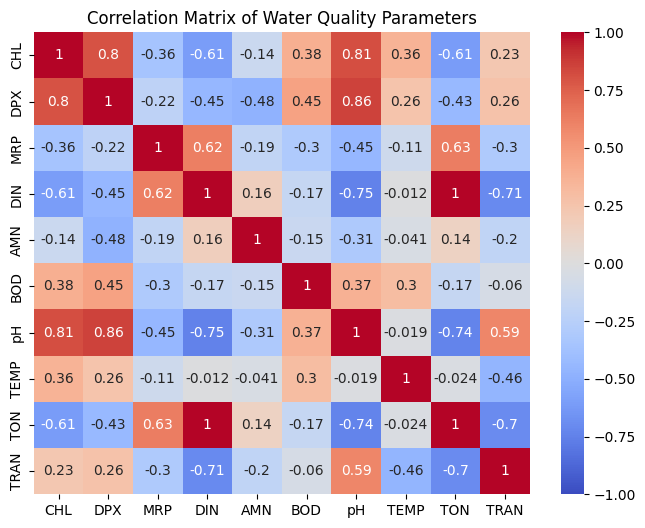

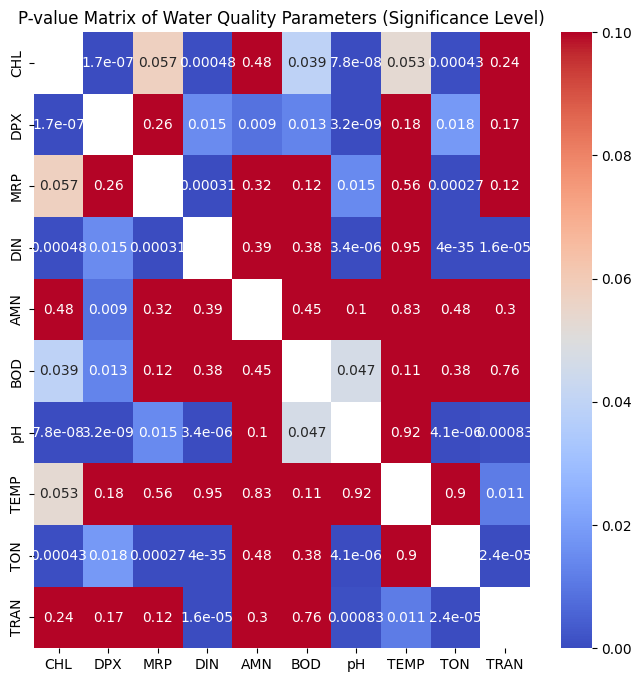

In [37]:
# Calculate the correlation matrix
dp=dp_I.iloc[6:]  # Irland data

corr_matrix = dp.corr()

# Optionally visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Water Quality Parameters")
plt.show()

# Initialize an empty DataFrame to hold the p-values
p_values = pd.DataFrame(np.zeros((dp_I.shape[1], dp_I.shape[1])), columns=dp_I.columns, index=dp_I.columns)

# Calculate the Pearson correlation coefficient and p-value for each pair
for col1 in dp.columns:
    for col2 in dp.columns:
        if col1 != col2:
            corr, p_val = pearsonr(dp[col1], dp[col2])
            p_values.loc[col1, col2] = p_val
        else:
            p_values.loc[col1, col2] = np.nan  # No p-value for correlation of a variable with itself


# Optionally visualize the p-value matrix
plt.figure(figsize=(8, 8))
sns.heatmap(p_values, annot=True, cmap='coolwarm', vmin=0, vmax=0.1)
plt.title("P-value Matrix of Water Quality Parameters (Significance Level)")
plt.show()


### Models

In [38]:
## standart values for Irland
dp=dp_I
st_up=dp.iloc[0]
st_low=dp.iloc[1]
x_up=dp.iloc[4]
x_low=dp.iloc[5]


#### SI, Results fuction

In [39]:
## Sub index calculate
# CHL=0,DOX=1,MRP=2,DIN=3,AMN=4,BOD=5,pH=6,TEMP=7,TON=8,TRAN=9
def SI1(x,x_up,x_low):
  return max(0,(x_up-x)/(x_up-x_low)*100)

def SI2(x,x_up,x_low):
  return max(0,(x-x_low)/(x_up-x_low)*100)

def SI(i,x,x_up,x_low):
  a=[0,2,3,4,5,8]
  if i in a:
    return SI1(x,x_up,x_low)
  if i==1:
    if x>100:
      return SI2(x,x_up,x_low)
    elif x<100:
      return SI1(x,x_up,x_low)
    else:
      return 100
  if i==6:
    if x<7.5:
      return SI2(x,x_up,x_low)
    elif x>8.5:
      return SI1(x,x_up,x_low)
    else:
      return 100
  if i==7:
    if x<25:
      return 100
    else:
      return 0
  if i==9:
    if x<1:
      return SI1(x,x_up,x_low)
    else:
      return 100


In [40]:
## Results
def result(x):
  if x<30:
    return 'Poor'
  elif x<50:
    return 'Marginal'
  elif x<80:
    return 'Fair'
  else:
    return 'Good'

#### NSF model

In [41]:

def NSF(x):

  ## Sub indexing
  s=[]
  for i in range(len(x)):
    si=SI(i,x.iloc[i],x_up.iloc[i],x_low.iloc[i])
    s.append(si)

  ## weights
  w=dp.iloc[2]

  ## calculation NSF WQI
  NSF=round(np.dot(s,w))
  return NSF, result(NSF)

x=dp.iloc[6]
NSF(x)

(53, 'Fair')

#### WQM

In [42]:
def WQM(x):
  ## Sub indexing
  s=[]
  for i in range(len(x)):
    si=SI(i,x.iloc[i],x_up.iloc[i],x_low.iloc[i])*SI(i,x.iloc[i],st_up.iloc[i],st_low.iloc[i])
    s.append(si)

  ## weights
  w=dp.iloc[3]

  ## calculation NSF WQI
  WQM=round(np.sqrt(np.dot(s,w)))
  return WQM, result(WQM)

x=dp.iloc[6]
WQM(x)

(87, 'Good')

#### CCME

In [43]:
def CCME(x):
  Total_p=len(x)
  Failed_p=0
  for i in range(len(x)):
    if x.iloc[i]>st_up.iloc[i]:
      Failed_p=+1
  F1=Failed_p/Total_p*100
  F2=F1
  exceursion=0
  for i in range(len(x)):
    if x.iloc[i]>st_up.iloc[i]:
      exceursion=exceursion+x.iloc[i]/st_up.iloc[i]-1
  nse=exceursion/Total_p
  F3=nse/(1+nse)*100
  CCME=100-np.sqrt(F1*F1+F2*F2+F3*F3)/1.732
  return round(CCME), result(CCME)

x=dp.iloc[6]
CCME(x)

(86, 'Good')

#### WA(Weighted Avarage)

In [44]:
def WA(x):
  # calculating weights
  ssi=[1/s for s in st_up]
  S=np.sum(ssi)
  w=[s/S for s in ssi]
  ## Sub indexing
  s=[]
  for i in range(len(x)):
    si=100-SI(i,x.iloc[i],st_up.iloc[i],st_low.iloc[i])
    s.append(si)

  # calculating index
  WA=max(0,100-np.dot(s,w))
  return round(WA), result(WA)

x=dp.iloc[6]
WA(x)

(76, 'Fair')

#### DWA

In [45]:
## Sub index calculate
# CHL=0,DOX=1,MRP=2,DIN=3,AMN=4,BOD=5,pH=6,TEMP=7,TON=8,TRAN=9
def QI1(x,x_up,x_low):
  return min(100,(x-x_low)/(x_up-x_low)*100)


def QI(i,x,x_up,x_low):
  a=[0,2,3,4,5,8]
  if i in a:
    return QI1(x,x_up,x_low)
  if i==1:
    return abs(QI1(x,x_up,(x_up+x_low)/2))
  if i==6:
    return abs(QI1(x,x_up,(x_up+x_low)/2))
  if i==7:
    if x<25:
      return 0
    else:
      return 100
  if i==9:
    if x<1:
      return (1-x)*100
    else:
      return 0


def DWA(x):
  ## Sub indexing
  s=[]
  ss=[]
  for i in range(len(x)):
    si=QI(i,x.iloc[i],st_up.iloc[i],st_low.iloc[i])
    s.append(si)
    ss.append(np.exp((si/100))-1)
  S=np.sum(ss)
  # weights
  w=[x/S for x in ss]
  #print(w)
  #print(s)
  #Calculating WQI
  DWA=100-max(0,np.dot(s,w))
  return round(DWA), result(DWA)

x=dp.iloc[34]
#print(x)
DWA(x)

(64, 'Fair')

### Eclipsing impacts Hypothesis testing

##### Creating data

In [54]:
t_NSF=[]
t_WQM=[]
t_CCME=[]
t_WA=[]
t_DWA=[]
d_NSF=[]
d_WQM=[]
d_CCME=[]
d_WA=[]
d_DWA=[]

for i in range(len(dp.iloc[6:])):
  x=dp.iloc[i+6]
  t_NSF.append(NSF(x)[0])
  t_WQM.append(WQM(x)[0])
  t_CCME.append(CCME(x)[0])
  t_WA.append(WA(x)[0])
  t_DWA.append(DWA(x)[0])
  d_NSF.append(NSF(x)[1])
  d_WQM.append(WQM(x)[1])
  d_CCME.append(CCME(x)[1])
  d_WA.append(WA(x)[1])
  d_DWA.append(DWA(x)[1])

df=dp.iloc[6:]
df = df.assign(NSF=d_NSF)
df['WQM']=d_WQM
df['CCME']=d_CCME
df['WA']=d_WA
df['DWA']=d_DWA
df['NSFn']=t_NSF
df['WQMn']=t_WQM
df['CCMEn']=t_CCME
df['WAn']=t_WA
df['DWAn']=t_DWA

df.head(5)


,CHL,DPX,MRP,DIN,AMN,BOD,pH,TEMP,TON,TRAN,NSF,WQM,CCME,WA,DWA,NSFn,WQMn,CCMEn,WAn,DWAn
6,1.000,69.33,0.011,3.423,0.260,1.37,7.6,15.00,3.17,0.0,Fair,Good,Good,Fair,Poor,53,87,86,76,8
7,1.900,103.30,0.011,2.258,0.060,3.55,7.9,15.43,2.20,0.0,Marginal,Good,Good,Fair,Poor,40,89,90,76,16
8,2.033,98.00,0.015,1.992,0.025,1.30,7.7,16.80,1.97,0.0,Marginal,Good,Good,Fair,Poor,47,90,91,70,14
9,1.450,93.33,0.018,2.640,0.039,1.33,7.7,16.13,2.60,0.0,Marginal,Good,Good,Fair,Poor,47,90,89,66,16
10,2.500,89.33,0.028,2.394,0.060,1.25,7.8,15.83,2.30,1.5,Marginal,Good,Good,Fair,Poor,47,83,90,50,23


##### Model testing

Gepoteza tekshirish uchun kreteriy yozamiz.

1. Meyordan oshgan yoki kamaygan natijalar bor tanlanma yaxshi 'Good' emas.
2. Hammasi meyorda bo'lgan tanlanma yomon 'Poor' emas.

Shu tasdiqlarni qaysi model ko'proq qanoatlantiririshini tekshiramiz.

{'NSF': 0, 'WQM': 13, 'CCME': 13, 'WA': 1, 'DWA': 0}


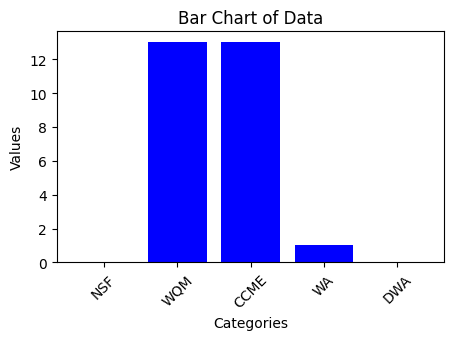

In [55]:
def xato_bor(x):
  for i in range(len(x)):
    if x.iloc[i] > st_up.iloc[i] or x.iloc[i] < st_low.iloc[i]:
      return True
  return False


t_NSF=0
t_WQM=0
t_CCME=0
t_WA=0
t_DWA=0

for i in range(len(dp.iloc[6:])):
  x=dp.iloc[i+6]
  if xato_bor(x)==True:
    if NSF(x)[1]=='Good': t_NSF+=1
    if WQM(x)[1]=='Good': t_WQM+=1
    if CCME(x)[1]=='Good': t_CCME+=1
    if WA(x)[1]=='Good': t_WA+=1
    if DWA(x)[1]=='Good': t_DWA+=1

  else:
    if NSF(x)[1]=='Poor': t_NSF+=1
    if WQM(x)[1]=='Poor': t_WQM+=1
    if CCME(x)[1]=='Poor': t_CCME+=1
    if WA(x)[1]=='Poor': t_WA+=1
    if DWA(x)[1]=='Poor': t_DWA+=1



t={'NSF':t_NSF,'WQM':t_WQM,'CCME':t_CCME,'WA':t_WA,'DWA':t_DWA}
print(t)
# Extract data for plotting
labels = list(t.keys())
values = list(t.values())

# Create the bar chart
plt.figure(figsize=(5, 3))
plt.bar(labels, values, color='blue')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Chart of Data')

# Rotate labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

##### Calculating Mean, std

In [56]:
df1=dp.iloc[6:]

# Calculate mean and standard deviation
mean_values = df1.mean()
std_values = df1.std()

# Create a new DataFrame with the results
results_df = pd.DataFrame({
    'Mean': mean_values,
    'Standard Deviation': std_values
})

# Print the table
print(results_df)

            Mean  Standard Deviation
CHL     5.321207            3.219069
DPX   107.900690           15.185834
MRP     0.020034            0.012004
DIN     1.544069            1.782734
AMN     0.070310            0.055968
BOD     1.737241            0.871628
pH      8.011379            0.241952
TEMP   15.585172            0.737775
TON     1.477000            1.787266
TRAN    1.570345            1.475370


##### Monte Carlo Simulation Gaussian Processes

In [58]:
num_samples = 1000  # Adjust the number of samples as needed
new_data = np.random.normal(mean_values, std_values, (num_samples, len(mean_values)))

new_df = pd.DataFrame(new_data, columns=df1.columns)

new_df.head(5)

,CHL,DPX,MRP,DIN,AMN,BOD,pH,TEMP,TON,TRAN
0,7.334472,133.827981,0.024295,1.456948,0.059401,1.575376,8.099335,16.309214,1.656557,2.484931
1,8.745695,109.441295,0.016056,1.603432,0.021261,2.943557,8.418675,14.393280,3.828213,2.237176
2,1.104314,92.831196,0.018643,1.072529,0.088984,1.416241,8.166421,15.438511,-0.250790,2.136093
3,7.377265,129.538319,0.018200,0.069350,-0.004643,2.592588,8.476305,15.977128,-1.995791,2.012349
4,9.946194,112.166514,0.038577,0.479924,-0.013027,1.969958,8.025257,14.912826,3.538919,1.086437


##### Model fit graph

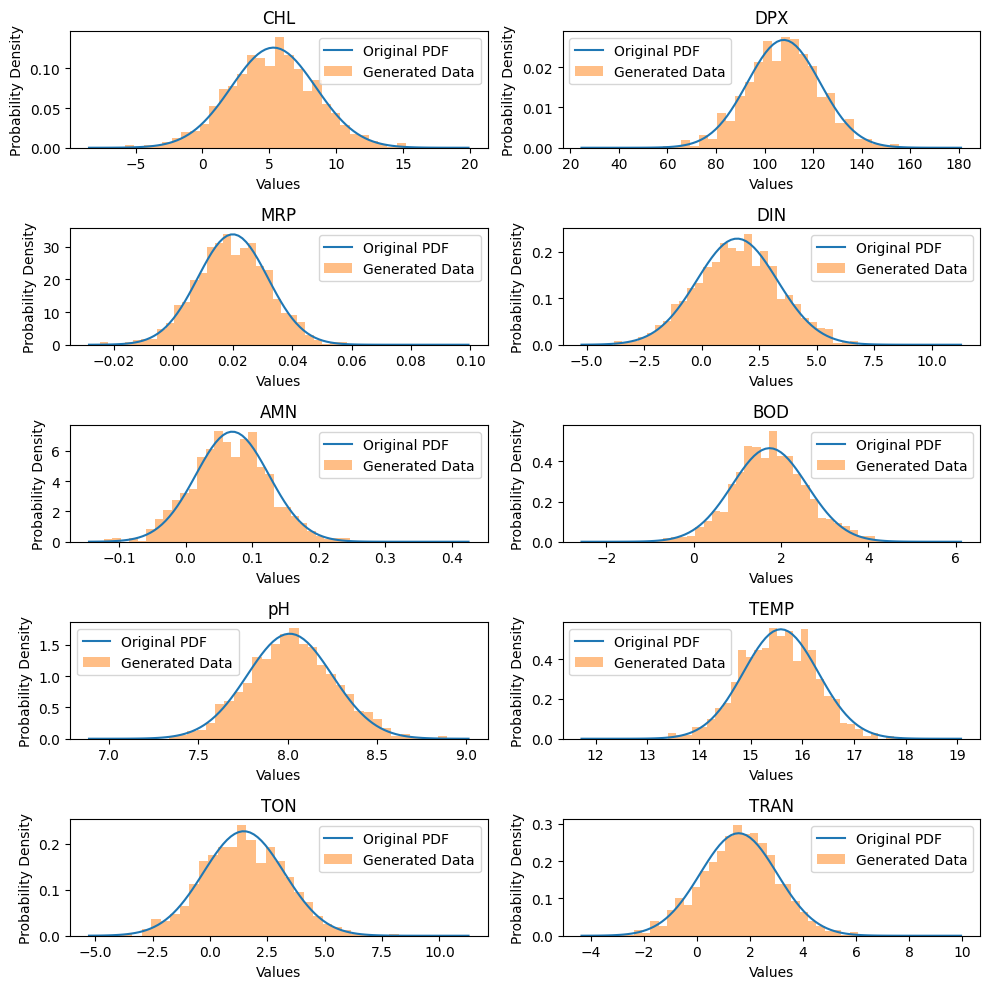

In [61]:
import scipy.stats as stats

fig, axes = plt.subplots(nrows=int(np.ceil(len(df1.columns) / 2)), ncols=2, figsize=(10, 10))

for i, column in enumerate(df1.columns):
    data = df1[column]
    mu, sigma = stats.norm.fit(data)
    x = np.linspace(min(data) - 3 * sigma, max(data) + 3 * sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    axes.flatten()[i].plot(x, y, label='Original PDF')
    axes.flatten()[i].hist(new_df[column], bins=30, density=True, alpha=0.5, label='Generated Data')
    axes.flatten()[i].set_title(column)
    axes.flatten()[i].set_xlabel('Values')
    axes.flatten()[i].set_ylabel('Probability Density')
    axes.flatten()[i].legend()

plt.tight_layout()
plt.show()


#### Model testing with new data

{'NSF': 0, 'WQM': 808, 'CCME': 951, 'WA': 227, 'DWA': 7}


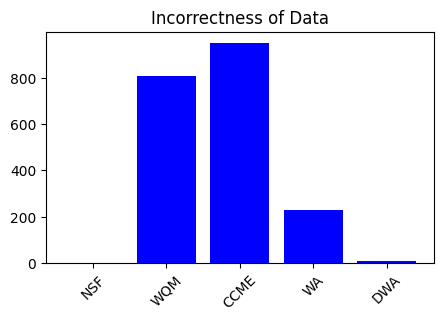

In [62]:
t_NSF=0
t_WQM=0
t_CCME=0
t_WA=0
t_DWA=0

for i in range(len(new_df)):
  x=new_df.iloc[i]
  if xato_bor(x)==True:
    if NSF(x)[1]=='Good': t_NSF+=1
    if WQM(x)[1]=='Good': t_WQM+=1
    if CCME(x)[1]=='Good': t_CCME+=1
    if WA(x)[1]=='Good': t_WA+=1
    if DWA(x)[1]=='Good': t_DWA+=1

  else:
    if NSF(x)[1]=='Poor': t_NSF+=1
    if WQM(x)[1]=='Poor': t_WQM+=1
    if CCME(x)[1]=='Poor': t_CCME+=1
    if WA(x)[1]=='Poor': t_WA+=1
    if DWA(x)[1]=='Poor': t_DWA+=1



t={'NSF':t_NSF,'WQM':t_WQM,'CCME':t_CCME,'WA':t_WA,'DWA':t_DWA}
print(t)


labels = list(t.keys())
values = list(t.values())


plt.figure(figsize=(5, 3))
plt.bar(labels, values, color='blue')
plt.title('Incorrectness of Data')
plt.xticks(rotation=45)
plt.show()

#### Hypothesis testing for models

In [63]:
H0 = 0.005   # null hypothesis
alpha = 0.05  # Significance level

print('p-values')
for model_name in t:
    p_values = binomtest(t[model_name], 1000, p=H0).pvalue
    if p_values < alpha:
        text='H0 qabul qilinmasligiga statistik asos bor'
    else:
        text='H0 qabul qilinishiga statistik asos bor'

    print(model_name,'----',f"{p_values:.3f}",'----',text)


p-values
NSF ---- 0.012 ---- H0 qabul qilinmasligiga statistik asos bor
WQM ---- 0.000 ---- H0 qabul qilinmasligiga statistik asos bor
CCME ---- 0.000 ---- H0 qabul qilinmasligiga statistik asos bor
WA ---- 0.000 ---- H0 qabul qilinmasligiga statistik asos bor
DWA ---- 0.361 ---- H0 qabul qilinishiga statistik asos bor


### Compare distributions for each models for Irland data

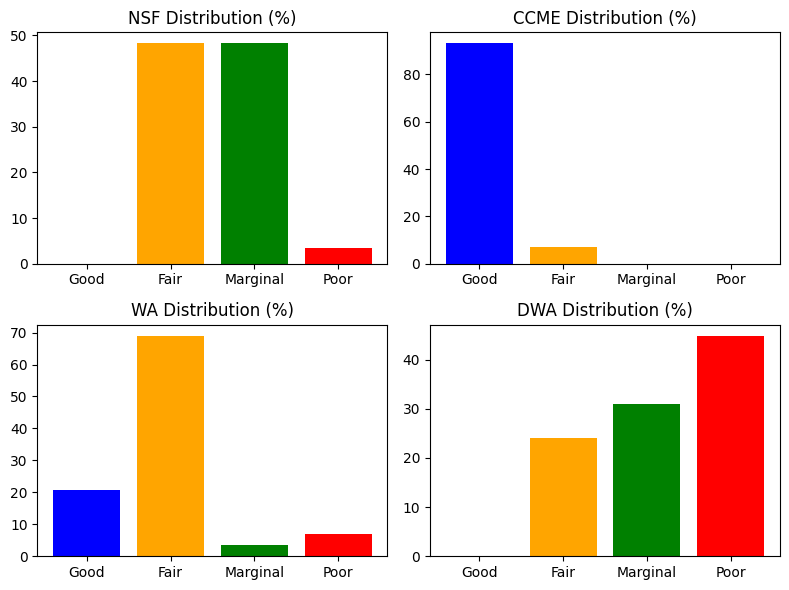

In [64]:
df = df[['NSF',	'CCME',	'WA',	'DWA']]

categories = ['Good', 'Fair', 'Marginal', 'Poor']

freq_dict = {}
for col in df.columns:
    value_counts = df[col].value_counts().to_dict()
    freq_dict[col] = {category: value_counts.get(category, 0) for category in categories}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

if len(freq_dict) > 1:
    axes = axes.flatten()

for i, (model, counts) in enumerate(freq_dict.items()):
    total = sum(counts.values())
    percentages = [(counts[cat] / total) * 100 for cat in categories]
    axes[i].bar(categories, percentages, color=['blue', 'orange', 'green', 'red'])
    axes[i].set_title(f'{model} Distribution (%)')




plt.tight_layout()
plt.show()